In [1]:
import json
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from climdist.data import load as load_df
from scipy.signal import find_peaks

In [24]:
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('../data/models/word2vec_251021/w2v_model.txt')

In [47]:
df = load_df('main', readability=False, heading2=False)

## WEA frequency counts

In [2]:
# load all entities captured by model
with open('../data/processed/entities.json', 'r', encoding='utf8') as f:
    ents = json.load(f)

In [2]:
# load all entities captured by ruler
with open('../data/processed/entities_ruled.json', 'r', encoding='utf8') as f:
    ents_ruled = json.load(f)

In [3]:
print(len(ents_ruled))

289705


In [5]:
# total nb of entities detected

# ents_detected = 0
# 
# for entry in ents_ruled:
#     ents_detected += len(entry['ents']['WEA'])
# 
# print(ents_detected)

122281


In [4]:
def find_wea_freqs(ents):
    
    results = {}
    
    for entry in tqdm(ents):
        wea_ents = entry['ents']['WEA']
        if len(wea_ents) != 0:
            for ent in wea_ents:
                if ent[0] in results.keys():
                    results[ent[0]] += 1
                else:
                    results[ent[0]] = 1
                    
    return {key: value for (key, value) in sorted(results.items(), key=lambda x:x[1], reverse=True)}

In [67]:
wea_freqs = find_wea_freqs(ents)

100%|██████████████████████████████████████████████████████████████████████| 256996/256996 [00:00<00:00, 543839.55it/s]


In [68]:
wea_freqs_ruled = find_wea_freqs(ents_ruled)

100%|█████████████████████████████████████████████████████████████████████| 289705/289705 [00:00<00:00, 1049031.34it/s]


In [10]:
with open('../data/processed/wea_freq_counts.json', 'w', encoding='utf8') as f:
    json.dump(wea_freqs, f)
    
with open('../data/processed/wea_freq_counts_ruled.json', 'w', encoding='utf8') as f:
    json.dump(wea_freqs_ruled, f)

## Wordclouds for all entities (NER and ruled)

<Figure size 864x576 with 0 Axes>

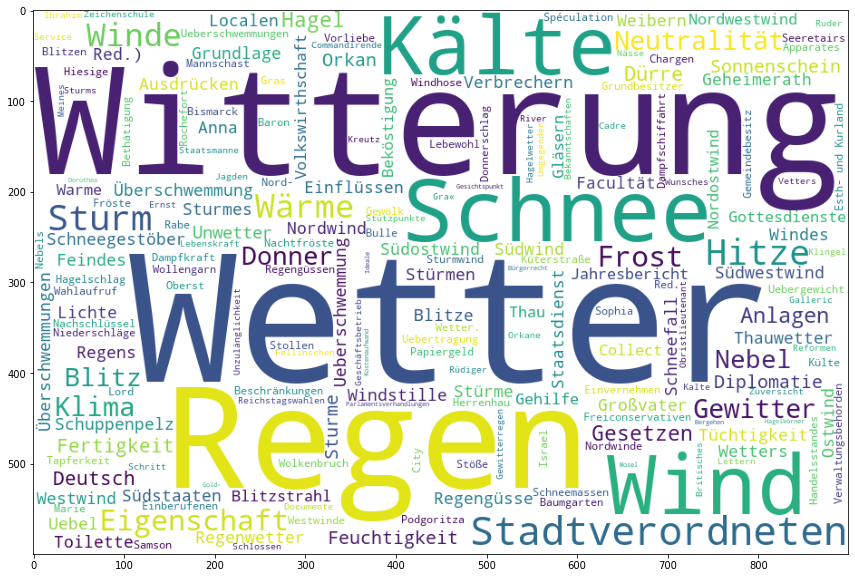

In [81]:
plt.figure(figsize=(12,8))
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(wea_freqs)
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.savefig('../references/inalco/general_cloud_ner.png', bbox_inches='tight')
plt.show()

<Figure size 864x576 with 0 Axes>

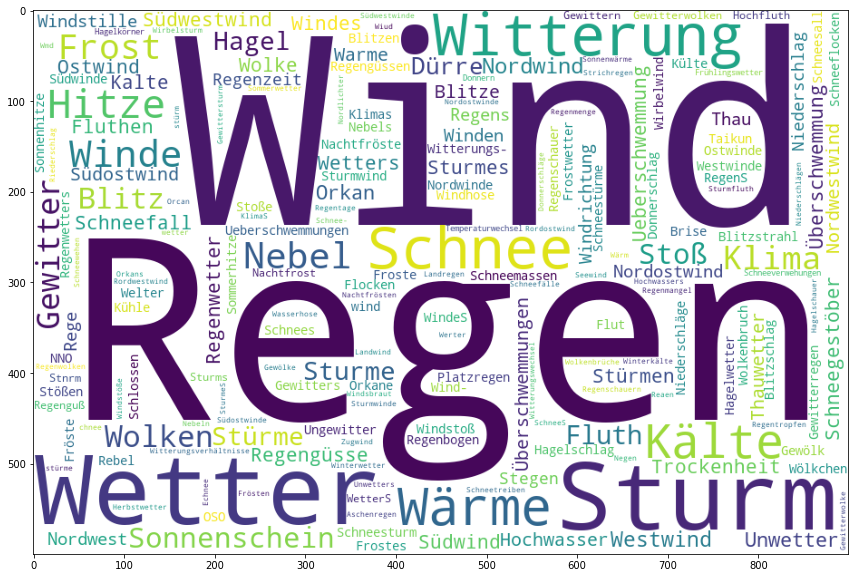

In [83]:
plt.figure(figsize=(12,8))
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(wea_freqs_ruled)
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.savefig('../references/inalco/general_cloud_ruled.png', bbox_inches='tight')
plt.show()

## Single entity frequencies

<AxesSubplot:xlabel='year'>

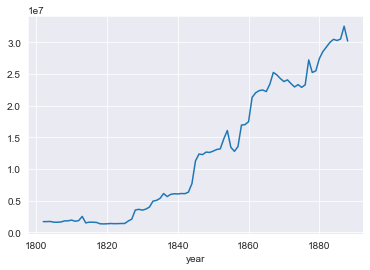

In [98]:
text_lens = df.groupby('year')['text_len'].sum()
text_lens.plot()

In [27]:
with open('../pipeline/ner/ruler_patterns_171121.json', 'r', encoding='utf8') as f:
    wea_patterns = json.load(f)
    wea_patterns = [entry['pattern'] for entry in wea_patterns]

In [36]:
orkan_list = ['Orkan', 'Orkane', 'Orcan', 'Orkans']
sturm_list = ['Sturm', 'Weststurm', 'SturmeS', 'Schneestürme', 'Schneesturm', 'Schneestürmen', 'Unwetter', 'Sturmwind',
              'Schneesturme', 'Sturmwinde', 'Gewittersturm', 'Orkane', 'Orcan', 'Orkan', 'Orkans', 'Stürm',
              'Stnrm', 'Wirbelwinde', 'Südweststurm', 'Nordsturm', 'Nordweststurm', 'Ungewitter', 'Sturmwetter',
              'Sturmwetter', 'Sturms', 'Schneesturmes', 'Stnrmes', 'Sturmwindes', 'Wirbelwindes', 'Herbststürme',
              'Srurm', 'Slurm', 'Stürme', 'Stürmen', 'Eturm', 'stürme', 'stürm', 'Seesturm', 'Gewitterstürme',
              'Aequinoctialstürme', 'Stnrme', 'Typhon', 'Taikun']
exotic_wind_list = ['Typhon', 'Taikun', 'Aequinoctialstürme']

In [41]:
wetter_witterung_list = ['Wetter', 'Welter', 'Witterung', 'Herbstwetter', 'Frühlingswetter', 'Werter',
                         'Wetters', 'Sommerwetter', 'FrühlingSwetter', 'Witteruug', 'Winterwetter', 'Maiwetter',
                         'Witternng', 'WetterS', 'Welters']
klima_list = ['Klima', 'Klimas', 'Clima', 'KlimaS']

In [208]:
def get_peaks(results, n=3):
    peaks = find_peaks(list(results.values()), distance=2, height=min(test_results.values()))
    peaks_dict = dict(zip(peaks[0], peaks[1]['peak_heights']))
    peaks_sorted = {key+1802: value for (key, value) in sorted(peaks_dict.items(), key=lambda x:x[1], reverse=True)}

    peaks_xy = []
    for num, peak in enumerate(peaks_sorted.items()):
        if num < n:
            peaks_xy.append(peak)
    
    return peaks_xy


def find_single_entity_freq(ents, target_list):
    
    results = {}
    
    for entry in ents:
        if len(entry['ents']['WEA']) > 0:
            year = int(entry['date'][:4])
            for ent in entry['ents']['WEA']:
                if ent[0] in target_list:
                    if year in results.keys():
                        results[year] += 1
                    else:
                        results[year] = 1
                        
    results_proportional = {}
    for key, value in results.items():
        results_proportional[key] = results[key]/text_lens[key]
    
    sns.set_style('darkgrid')
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    figure.tight_layout()
    
    ax1.plot(results.keys(), results.values(), label=target_list[0])
    ax1.set_title(f'"{target_list[0]}" occurrences')
    ax2.plot(results_proportional.keys(), results_proportional.values(), label=target_list[0])
    ax2.set_title(f'"{target_list[0]}" relative share')
    
    for peak in get_peaks(results):
        ax1.annotate(str(peak[0]), peak)
    for peak in get_peaks(results_proportional):
        ax2.annotate(str(peak[0]), peak)
    
    plt.legend()
    plt.show()

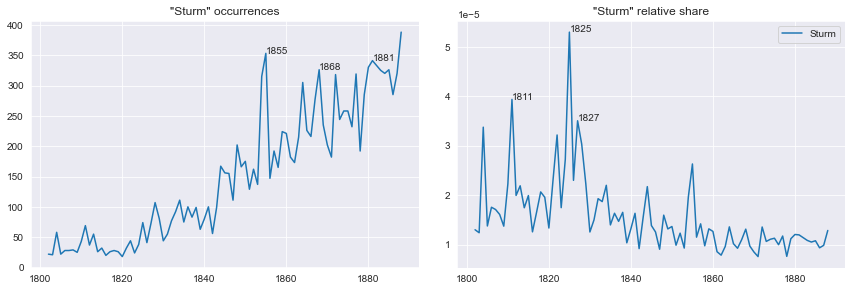

In [195]:
find_single_entity_freq(ents_ruled, sturm_list)

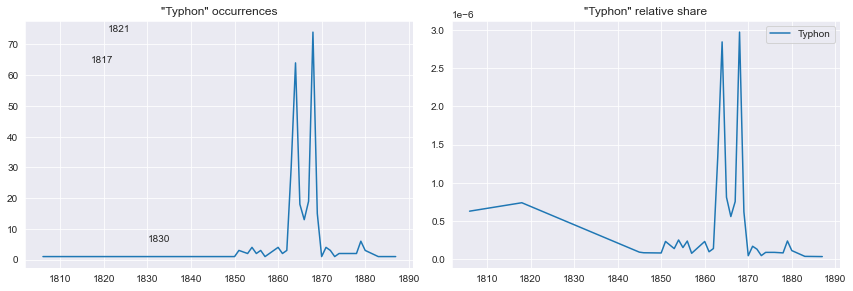

In [209]:
find_single_entity_freq(ents_ruled, exotic_wind_list)

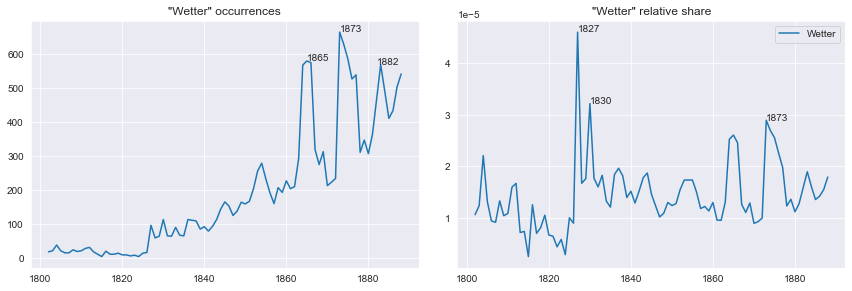

In [197]:
find_single_entity_freq(ents_ruled, wetter_witterung_list)

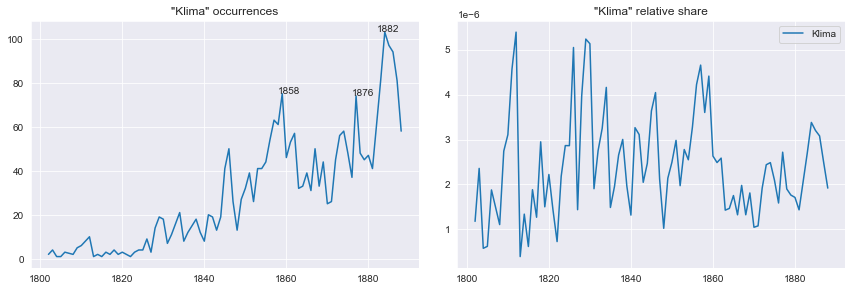

In [210]:
find_single_entity_freq(ents_ruled, klima_list)

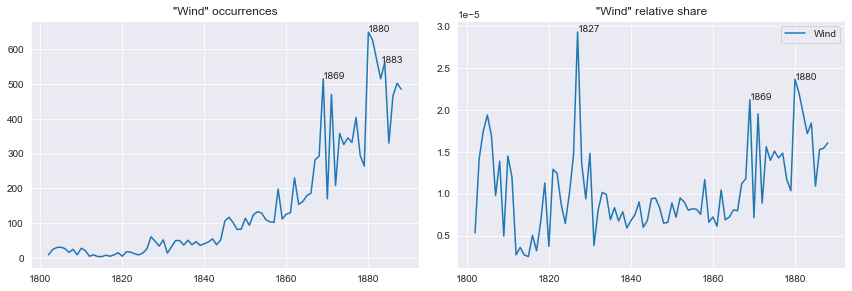

In [211]:
find_single_entity_freq(ents_ruled, ['Wind', 'Winde'])

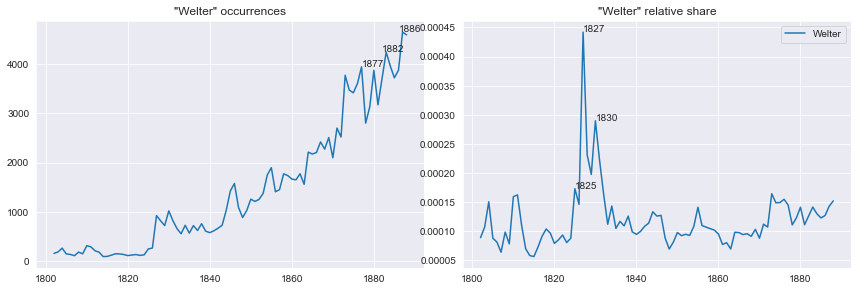

In [212]:
find_single_entity_freq(ents_ruled, wea_patterns)

In [221]:
ents_ruled[0]

{'id': 0, 'date': '1802-01-01', 'ents': {'WEA': []}}

In [229]:
def random_ents_from_year(year, df):
    ents_ruled_year = [ent for ent in ents_ruled if ent['date'][:4] == str(year)
                       and ent['ents']['WEA'] != []]
    
    year_df = df.loc[[ent['id'] for ent in ents_ruled_year]]
    
    print(f'{len(year_df)} texts with entities found from year {year}')
    
    while True:
        
        sample = year_df.sample()
        print('\n\n\n')
        print(sample.date.values[0], '\n')        
        print(sample.full_text.values[0])
        cont = input('continue? [Y]/n')
        if cont == 'n':
            break

In [230]:
random_ents_from_year(1827, df)

236 texts with entities found from year 1827




1827-01-25 

London, l?. Januar. Der gestrige Kvu» rier enthält Nachrichten aus Lissabon bis zum 2. d. Er bemerkt darüber: ~Aus den verschiedenen, im portug. Kriegs.Amt eingegan» penen Berichten scheint zu erhellen, daß di« Rebellen so thätig waren, daß die Truppen der Regierung genug zu thun hatten, auf olle ihre Bewegungen zu achten und ihren Spuren zu folgen, ohne fie zum Schlagen bringen zu können. Dieser ermüdende Krieg muß der

	England.

	Regierung sehr lästig fallen und gefahrbringend für die konstitutionelle Sache sey:,. Ein wich» tiger Umstand ist, dag die erste Nachricht von der Landung der engl. Truppen keinen Schreiten unter den Rebellen verbreitet hatte. Hierüber darf man sich jedoch nicht sehr «un, dem; die Rebellen führen eine verzweifelte Sache und wollen sie bis aufs Aeußerste tret, den; rechnen auch vielleicht auf das, was ste als eine zweideutige Beschaffenheit unserer Da» zwischenkunft ansehen. Sie folgern ohne Zweif

continue? [Y]/ny




1827-05-13 

Das niederländische Dampfschiff Willern de Eerste, geführt von Kapt. Jakob van den Oevcr, welches Sonnabend, den 5. Mai, Mor. GenS ~\ Uhr, von Hamburg abging, ist am 6. Mai, AbendS 9 Uhr, trotz der gehabten stür« mischen Witterung, in 37 Stunden in Amsterdam angekommen.
Dreöb en , iO. Mai. Vorgestern Vormkt. tagS wurde der hohe Leichnam Er. Maj. deS höchstseligen KönigS Friedrich August in dem Audienz. Zimmer auf das Paradebette gesetzt und zedermann von 10 biS 12 Uhr Mittags, so wie von 6 biS 7* Uhr AbendS, der Eingang in dieses Zimmer verstattet. Um 8 Uhr erfolgte mit den hergebrachten Eolennitäten die Bei-

	Deutschland.

	setzung in der k. Beg»uon&gt;pgruft unter der katholischen Hoftirche.
Berlin/ 12. Mai. Der Kaiser!, russ. wirkl. geh. Rath und Etaatsfekretair Graf Capodistrias ist von Paris hier angekommen.
(Börsen. Halle.)
AIS ein merkwürdiges Spiel des Zufalls hat man bemerkt, daß gerade vor 6 Jahren, fast um dieselbe Stunde, in welcher unser 

continue? [Y]/nj




1827-11-15 

Näheres über die Seeschlacht bei Navarin.

	Am 20. umMittag, wo der Wind günstig war, wurden die Zubereuungssignale gemacht; jeder nahm seinen Posten ein, das engl. Admiralschiff Afiaan berSpitze.gefolgtvom Albion u. Genoa, der Fregatte Sirene mlt der Flagge des Adm. Rigni, dem Scipion, Trident und Breslaw, dann dem russischen Admiralschiffe mit drei Linienschiffen und vier Fregatten.
Die Türken harten rundum in der Bai «ine Embossagelinie in Hufeifengestalt dreifach ge-, bildet, ein Ganzes von drei Linienschiffen, ei. nern rasirren Schiffe, ib Fregatten, 27 großen Korvetten und eben so vielen Briggs auS» wachend.
Die Hauptmacht war vom Einlaufe her rechtshin beisammen und bestand aus vier gro.

	Ben Fregatten, 2 Linienschiffen, einer großen Freyarte, einem Linienschiffe, dann aus Fregatten von verschiedenem Rang, die den Kon. Tour vollendeten und verstärkt in zweiter Linie durch die Korvetten und die Briggs.
Sechs Brander lagen an den äußersters Err* 

## Adjectives

In [1]:
import pandas as pd
from climdist.data import load as cd_load
import spacy
import json
from tqdm import tqdm

In [21]:
df = cd_load('main', readability=True, heading2=False)

In [19]:
nlp = spacy.load('de_core_news_md', disable=['ner'])

In [20]:
def find_adjectives(df, ents, nlp, label, ent_name, ent_strings):
    
    results = []
    
    for entry in tqdm(ents):
        if len(entry['ents'][label]) > 0:
            
            entry_ents = entry['ents'][label]
            entry_id = entry['id']
            #print(entry_id)
            
            # check if any of the ent labels are the ones we are looking for
            if set([ent[0] for ent in entry_ents]).intersection(ent_strings):
                    
                patterns = []
                                    
                for ent in entry_ents:
                    if ent[0] in ent_strings:
                        patterns.append({'label': 'WEA', 'pattern': ent[0]})
                                
                nlp.add_pipe('entity_ruler', last=True)
                ruler = nlp.get_pipe('entity_ruler')
                ruler.add_patterns(patterns)
                
                doc = nlp(df.full_text[entry_id])
                adjectives = []
                
                for token in doc:
                    if token.ent_type_ == label:
                        if token.pos_ in ['NOUN', 'PROPN']:
                            adjectives.extend([child.lemma_ for child in token.children if child.pos_ == 'ADJ'])
                            
                results.extend(adjectives)
                nlp.remove_pipe('entity_ruler')
                
                
            else:
                pass
             
        else:
            pass
        
        
    return {ent_name: results}            

In [22]:
regen_list = ['Regen', 'regen', 'Regenwetter', 'Negen', 'Regenschauer', 'Strichregen', 'Platzregen', 'Rege',
             'Regengüssen', 'Regens', 'RegenS', 'Regeu', 'Regenfall']

wetter_list = ['Welter', 'Witterung', 'Werter', 'Wetters', 'Witteruug', 'Witternng', 'WetterS']

In [129]:
if 'entity_ruler' in nlp.pipe_names:
    nlp.remove_pipe('entity_ruler')

regen_adjs = find_adjectives(df, ents, nlp, 'WEA', 'Regen', regen_list)
wetter_adjs = find_adjectives(df, ents, nlp, 'WEA', 'Wetter', wetter_list)

100%|█████████████████████████████████████████████████████████████████████████| 256996/256996 [24:35<00:00, 174.17it/s]


In [133]:
with open('../pipeline/ner/regen_adjectives.json', 'w', encoding='utf8') as f:
    json.dump(regen_adjs, f)
    
with open('../pipeline/ner/wetter_adjectives.json', 'w', encoding='utf8') as f:
    json.dump(wetter_adjs, f)

In [20]:
with open('../pipeline/ner/regen_adjectives.json', 'r', encoding='utf8') as f:
    regen_adjs = json.load(f)
    
with open('../pipeline/ner/wetter_adjectives.json', 'r', encoding='utf8') as f:
    wetter_adjs = json.load(f)

In [23]:
df_regen = pd.DataFrame(data=regen_adjs)
df_wetter = pd.DataFrame(data=wetter_adjs)

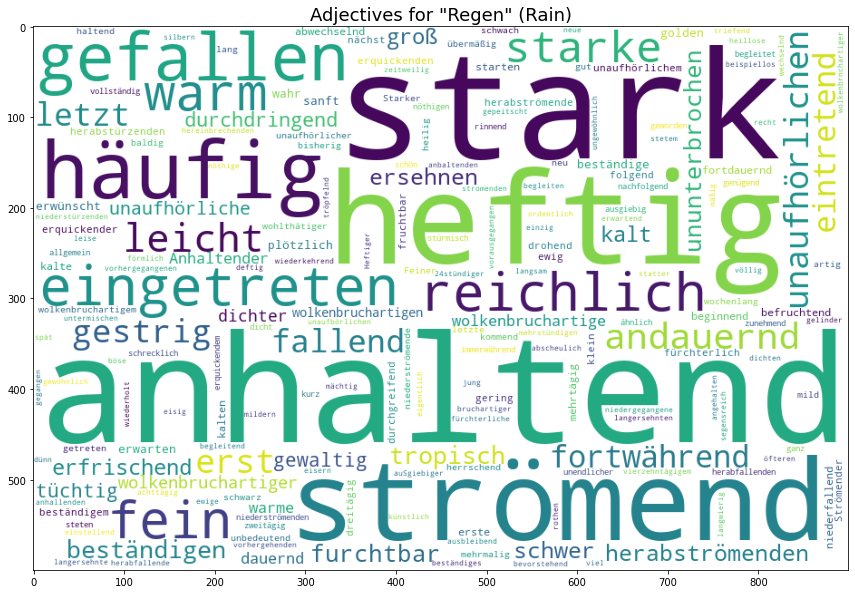

In [27]:
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(df_regen['Regen'].value_counts().to_dict())
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.title('Adjectives for "Regen" (Rain)', size=18)
plt.savefig('../references/MM_workshop/regen_adjs.png', bbox_inches='tight')
plt.show()

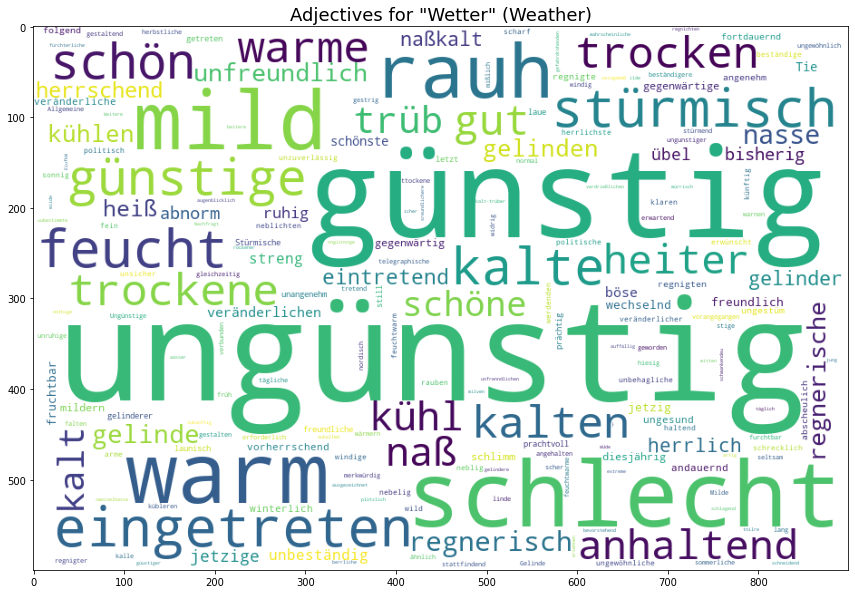

In [26]:
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(df_wetter['Wetter'].value_counts().to_dict())
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.title('Adjectives for "Wetter" (Weather)', size=18)
plt.savefig('../references/MM_workshop/wetter_adjs.png', bbox_inches='tight')
plt.show()

### Try splitting the timerange for adjectives

In [16]:
def split_ents(ents, year):
    
    year = str(year)
    
    for ix, entry in enumerate(ents):
        if entry['date'][:4] == year:
            split_ix = ix
            break
            
    return ents[:split_ix], ents[split_ix:]

In [17]:
ents1, ents2 = split_ents(ents, 1850)

In [23]:
if 'entity_ruler' in nlp.pipe_names:
    nlp.remove_pipe('entity_ruler')

wetter_adjs_early = find_adjectives(df, ents1, nlp, 'WEA', 'Wetter', wetter_list)
wetter_adjs_late = find_adjectives(df, ents2, nlp, 'WEA', 'Wetter', wetter_list)

100%|█████████████████████████████████████████████████████████████████████████| 159941/159941 [22:07<00:00, 120.52it/s]


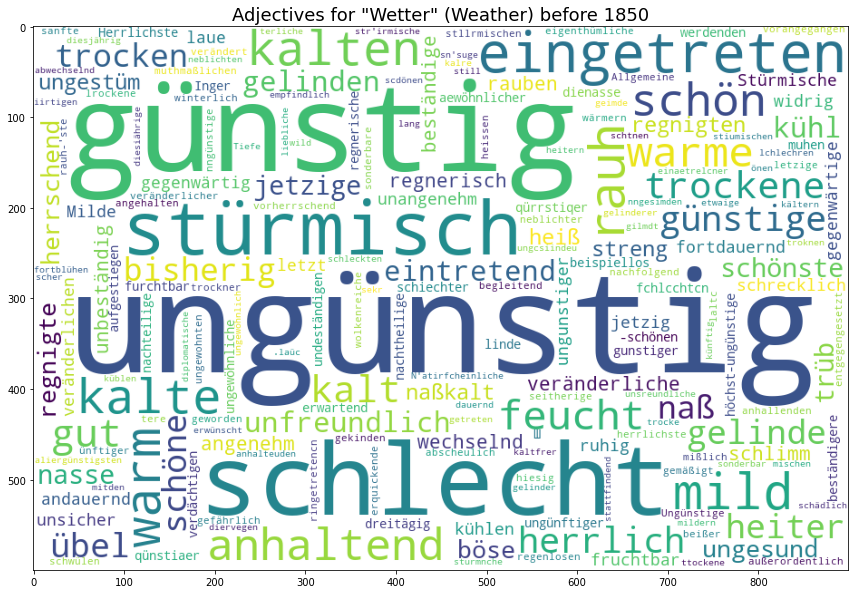

In [26]:
df_wetter_early = pd.DataFrame(data=wetter_adjs_early)

wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(df_wetter_early['Wetter'].value_counts().to_dict())
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.title('Adjectives for "Wetter" (Weather) before 1850', size=18)
plt.savefig('../references/inalco/wetter_adjs_early.png', bbox_inches='tight')
plt.show()

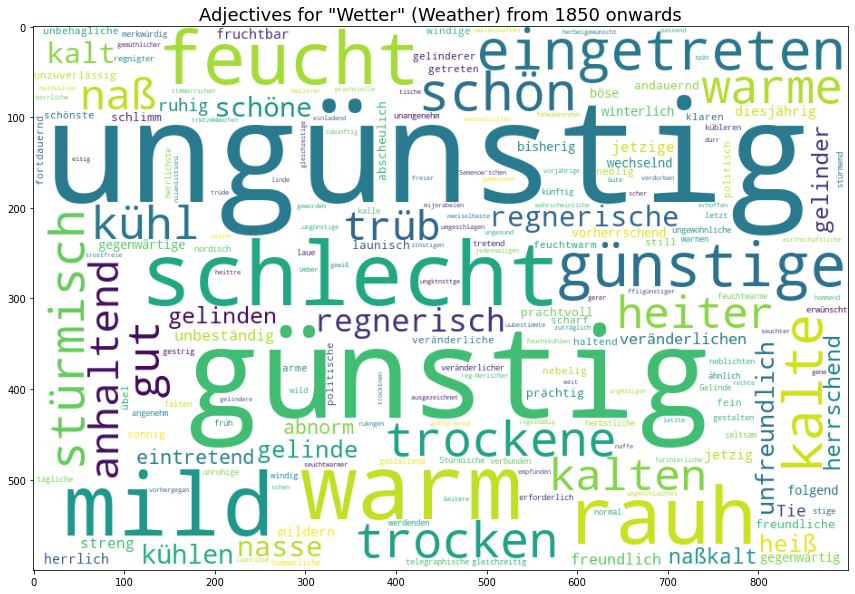

In [27]:
df_wetter_late = pd.DataFrame(data=wetter_adjs_late)

wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(df_wetter_late['Wetter'].value_counts().to_dict())
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.title('Adjectives for "Wetter" (Weather) from 1850 onwards', size=18)
plt.savefig('../references/inalco/wetter_adjs_late.png', bbox_inches='tight')
plt.show()

In [105]:
df_wetter_early['Wetter'].value_counts()[:10]

ungünstig      106
günstig         80
schlecht        49
stürmisch       35
eingetreten     27
warm            21
mild            21
rauh            20
kalten          19
kalte           19
Name: Wetter, dtype: int64

In [106]:
df_wetter_late['Wetter'].value_counts()[:10]

ungünstig      299
günstig        236
warm           108
schlecht       100
mild            97
rauh            79
feucht          66
günstige        60
eingetreten     60
kalte           55
Name: Wetter, dtype: int64

## PCA

Continue with ruled entities (less false positives)

In [61]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [35]:
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('../data/models/word2vec_251021/w2v_model.txt')

In [137]:
df_data = {word: list(model[word]) for (word, freq) in
           list(wea_freqs_ruled.items())[:100]
           if model.has_index_for(word)}
df = pd.DataFrame(df_data).transpose()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Wind,3.997121,-1.997144,-0.896162,-1.015114,-0.644477,5.687706,-0.398044,-4.558488,-2.631009,0.409658,...,-2.136814,0.583438,3.231198,1.095965,-1.395962,1.187891,0.579628,2.233373,0.842518,1.585546
Regen,4.597841,-1.278705,-0.924405,-0.310730,4.019860,6.215589,0.146798,-1.136845,1.547163,-0.099335,...,-1.369600,-0.462511,1.295471,-0.558615,-2.030243,1.398353,-1.667691,-1.582838,-2.764452,-0.416062
Wetter,1.378204,-2.707503,-2.039176,1.217988,2.243737,7.249822,0.605895,-0.760818,1.997465,1.639767,...,-1.648705,0.733798,1.211946,4.739862,-3.160194,3.041113,-2.772848,-0.826249,0.374688,-1.111655
Sturm,1.347576,-2.298337,-2.150306,2.419630,-0.502169,2.543556,-1.054247,-1.456778,-0.222191,1.185702,...,-0.365058,1.056712,2.059589,-1.064057,-0.979120,0.971783,-1.894031,-1.059706,-0.686569,-0.804395
Witterung,-0.005538,-7.517947,-0.256603,-0.812336,3.149959,6.066840,-0.382613,-0.186831,2.737664,0.334570,...,-2.412435,-0.453090,0.055757,1.896720,-4.634286,2.564435,-0.422497,1.706759,-0.234471,0.613567


In [139]:
# from: https://www.youtube.com/watch?v=Lsue2gEM9D0

pca = PCA()
pca.fit(df[:50])
pca_data = pca.transform(df[:50])

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

In [135]:
# plt.figure(figsize=(18,6))
# plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
# plt.ylabel('Percentage of Explained Variance')
# plt.xlabel('Principal Component')
# plt.title('Scree Plot')
# plt.show()

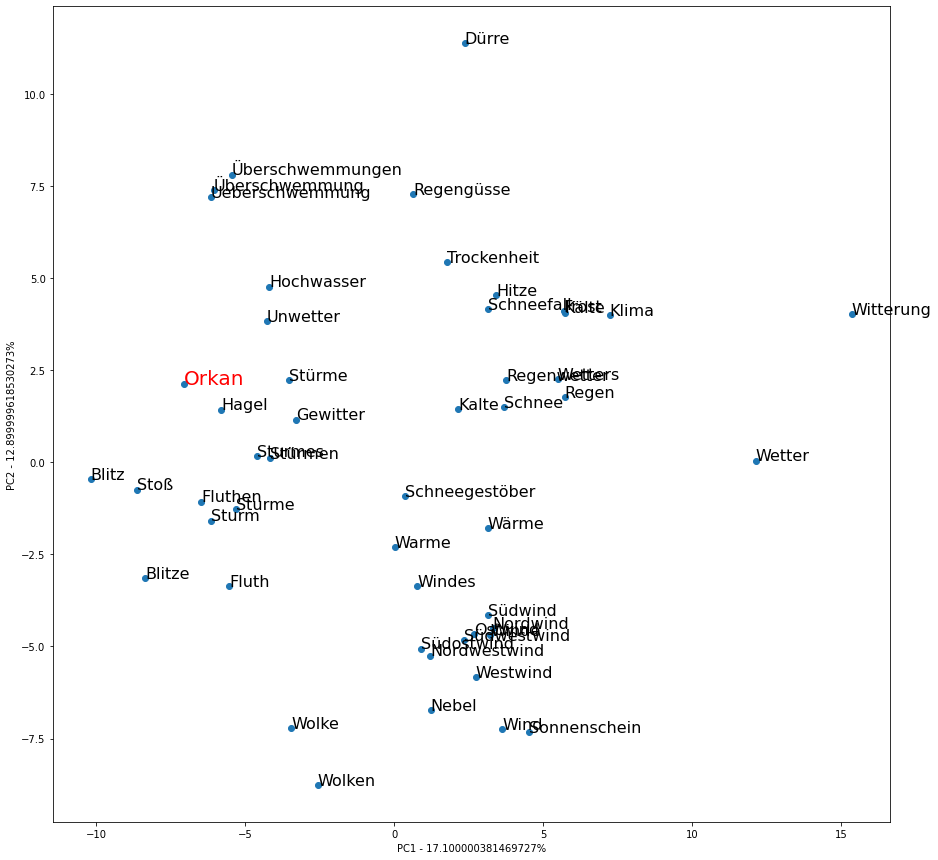

In [142]:
pca_df = pd.DataFrame(data=pca_data, index=df[:50].index, columns=labels)

plt.figure(figsize=(15,15))

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.xlabel('PC1 - {0}%'.format(round(per_var[0], 2)))
plt.ylabel('PC2 - {0}%'.format(round(per_var[1], 2)))
 
for sample in pca_df.index:
    if sample == 'Orkan':
        plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=20, color='red')
    else:
        plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=16)
        
plt.savefig('../references/inalco/orkan_pca.png', bbox_inches='tight')
plt.show()

## Geographical representation

In [130]:
def load_places(cities_minpop):
                   
    countries = pd.read_csv('../data/external/geonames/countries150721.tsv', sep='\t', encoding='utf8').convert_dtypes()
    cities = pd.read_csv('../data/external/geonames/cities150721.tsv', sep='\t', encoding='utf8').convert_dtypes()
    cities = cities[(cities.feature_code == 'PPLC')|(cities.population >= cities_minpop)]
    regions = pd.read_csv('../data/external/geonames/regions280721.tsv', sep='\t', encoding='utf8').convert_dtypes()
                   
    places = pd.concat([countries, cities, regions])
    places.name = ',' + places.name + ',' + places.alternatenames + ','
    places = places[['geonameid', 'name', 'y', 'x', 'population']]
    places = places.rename(columns={'name': 'names'})
                   
    return places

In [133]:
load_places(10000)

,geonameid,names,y,x,population
0,3041565,",Principality of Andorra,'Enitola,Andora,Andor...",42.55,1.58333,77006
1,290557,",United Arab Emirates,'Alepea Fakatahataha,A-l...",23.75,54.5,9630959
2,1149361,",Islamic Republic of Afghanistan,'Afikanisitan...",33.0,66.0,37172386
3,3576396,",Antigua and Barbuda,Aintige agus Barbuda,Aint...",17.05,-61.8,96286
4,783754,",Republic of Albania,'Alipania,Al'banija,Albaa...",41.0,20.0,2866376
...,...,...,...,...,...
527,12216908,<NA>,43.97233,22.11567,64630000
528,12217848,<NA>,50.28762,15.1903,166180000
529,12217933,<NA>,57.29568,19.48591,73370000
530,12217934,",Baltic States,https://en.wikipedia.org/wiki/B...",56.85514,25.32515,6040000


In [ ]:
def get_geodata(df, ents, year):
    
    df = pd.DataFrame(columns=)
    
    headings = df.heading2[(df.year == year) & (df.heading_loc == True)]
    headings = headings.value_counts().reset_index(name='count')
    headings = headings[headings['count'] > 1]
    headings = headings.rename(columns={'index': 'name'})
    
    headings['x'] = np.nan
    headings['y'] = np.nan
    
    notfound = []
    
    for name in headings.name:
        match = places[places.names.str.contains(','+name+',')]
        if len(match) == 1:
            headings.loc[headings.name == name, 'x'] = match.x.values
            headings.loc[headings.name == name, 'y'] = match.y.values
        elif len(match) > 1:
            match = match[match.population == max(match.population)]
            if len(match) == 1:
                headings.loc[headings.name == name, 'x'] = match.x.values
                headings.loc[headings.name == name, 'y'] = match.y.values
            else:
                match = match.sample(1)
                headings.loc[headings.name == name, 'x'] = match.x.values
                headings.loc[headings.name == name, 'y'] = match.y.values
        elif len(match) == 0:
            notfound.append(name)
            
    headings.dropna(0, 'any', inplace=True)
                        
    return headings.to_dict()